# Schelling's Model

## Objectives
- Implement an Agent-Based Model (ABM) to study how local micro-motives lead to global macro-segregation.
- Optimize neighbor-similarity calculations using 2D signal correlation techniques.
- Measure the Segregation Index to observe how small changes in individual tolerance thresholds ($p$) drastically alter the social landscape.

In [102]:
import numpy as np
from scipy.signal import correlate2d
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

class Schelling:
    def __init__(self, n, p):
        self.p = p
        choices = [0, 1, 2]  # 0 = empty, 1 = red, 2 = blue
        probs = [0.1, 0.45, 0.45]  # Probabilities for each choice
        self.array = np.random.choice(choices, (n, n), p=probs)

        self.kernel = np.array([[1, 1, 1],
                                 [1, 0, 1],
                                 [1, 1, 1]], dtype=np.int8)
        self.n = n
        
        # Initialize an array to store mean of frac_same at each step
        self.frac_same_means = []

    def locs_where(self, condition): 
        """Finds the locations where a condition is True."""
        return list(zip(*np.nonzero(condition)))

    def step(self):
        """Executes one step of the simulation."""
        a = self.array
        red = a == 1
        blue = a == 2
        empty = a == 0

        options = dict(mode='same', boundary='wrap')

        # Count neighboring reds and blues
        num_red = correlate2d(red, self.kernel, **options)
        num_blue = correlate2d(blue, self.kernel, **options)
        num_neighbors = num_red + num_blue

        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            frac_red = np.where(num_neighbors > 0, num_red / num_neighbors, 0)
            frac_blue = np.where(num_neighbors > 0, num_blue / num_neighbors, 0)
        

        # Compute the fraction of same-type neighbors
        frac_same = np.where(red, frac_red, frac_blue)
        frac_same[empty] = np.nan
        self.frac_same_means.append(np.nanmean(frac_same))

        # Find unhappy agents
        unhappy = frac_same < self.p
        unhappy_locs = self.locs_where(unhappy)

        # Find empty locations
        empty_locs = self.locs_where(empty)
        num_empty = len(empty_locs)

        # Move unhappy agents to random empty locations
        for source in unhappy_locs:
            if num_empty == 0:
                break  # No empty spots left to move to
            i = np.random.randint(num_empty)
            dest = empty_locs.pop(i)  # Choose a random empty location

            # Swap the agent with the empty cell
            a[dest] = a[source]
            a[source] = 0

            # Update the list of empty locations
            empty_locs.append(source)
            


In [103]:
p = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
segregation = [[] for _ in p] 
steps=100
n=50

for i in range(len(p)):
    grid = Schelling(n=n, p=p[i])
    
    for _ in range(steps):  
        grid.step()
    
    segregation[i] = grid.frac_same_means


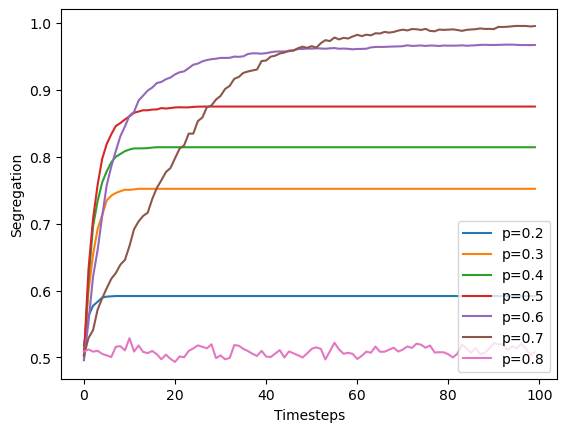

In [104]:
for i in range(len(segregation)):
    plt.plot(segregation[i], label=f"p={p[i]}")
plt.ylabel('Segregation')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

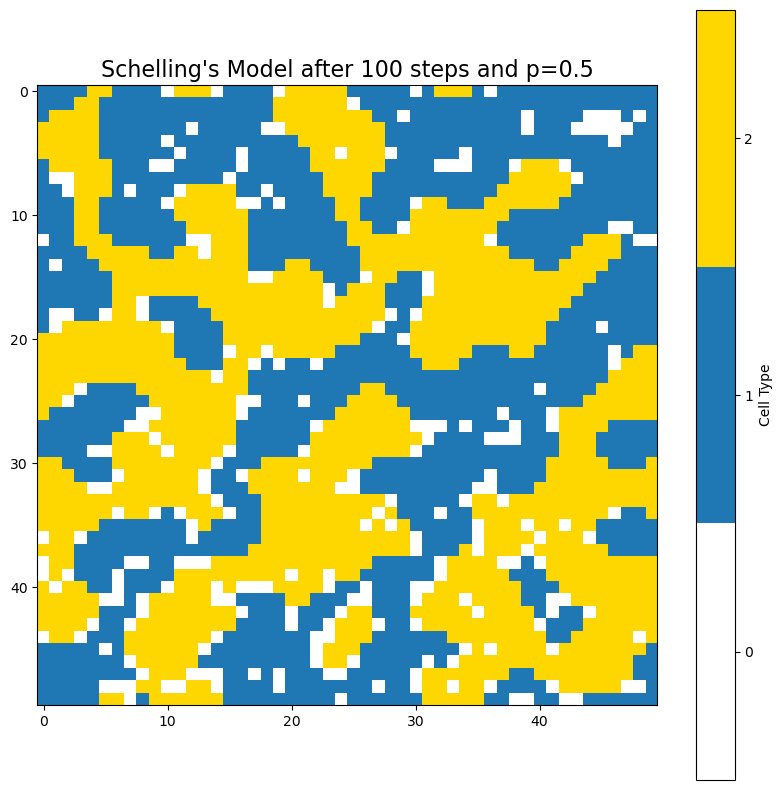

In [96]:
p=0.5
steps=100
n=50

grid = Schelling(n=n, p=p)

# Run the simulation
for i in range(steps):
    grid.step()

# Define a custom colormap:
custom_cmap = ListedColormap(["white", "tab:blue", "gold"])

# Visualize the final grid
plt.figure(figsize=(10, 10))
plt.imshow(grid.array, cmap=custom_cmap, interpolation="nearest")
plt.title(f"Schelling\'s Model after {steps} steps and p={p}", fontsize=16)
plt.colorbar(ticks=[0, 1, 2], label="Cell Type")
plt.clim(-0.5, 2.5)  # Set the range for color values
plt.show()